# Exploratory Data Analysis Part 2:
## Feature Extraction

From the previous notebook, a few features were ommited from analysis due to their complexity.  They will be evaluated here.

Per the previous notebook:

The remaining features which have not yet been investigated are provided as follows, along with a brief plan to evaluate each of those features:
* amenities
    * These need to be separated out into the individual amenties, counted up, and one hot encoded
* description
    * This will require some manual examination and NLP techniques to attmept to find useful features
* host_about
    * This will require some manual examination and NLP techniques to attmept to find useful features
* name
    * This will require some manual examination and NLP techniques to attmept to find useful features
* neighborhood_overview
    * This will require some manual examination and NLP techniques to attmept to find useful features
* host_location
    * This will need to be combined with host_neighbourhood and encoded accordingly
* host_neighbourhood
    * This will need to be combined with host_location and encoded accordingly


In [129]:
# Basic Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# For tesxt:
import re

# For times:
import time

# Set a random seed for imputation
#  Source:  https://numpy.org/doc/stable/reference/random/generated/numpy.random.seed.html
np.random.seed(42)

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Read Data and Examine Dataframe

In [8]:
# keep the same dataframe name as in the previous notebook
lstn = pd.read_csv('../data/listings_train_2.csv')

In [9]:
lstn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3477 entries, 0 to 3476
Data columns (total 56 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            3477 non-null   int64  
 1   name                                          3477 non-null   object 
 2   description                                   3464 non-null   object 
 3   neighborhood_overview                         2245 non-null   object 
 4   host_id                                       3477 non-null   int64  
 5   host_since                                    3477 non-null   float64
 6   host_location                                 2683 non-null   object 
 7   host_about                                    2463 non-null   object 
 8   host_response_time                            3477 non-null   object 
 9   host_response_rate                            3477 non-null   f

# Required Functions from Previous Notebook

In [255]:
# Create a more advanced 'plot vs' function which examines logs too

def plot_vs_log(data_x, data_y, title = None, x_lbl = None, y_lbl = None, size = (15,4), x_log = None, y_log = None):
    
    # calculate the correlations
    #  Source for correlation:  https://www.educative.io/answers/what-is-the-statistics-correlation-method-in-python
    
    # NaNs need to be dropped, in doing that, the array dimensions mmust match
    #  To do that, indices will be compared to get the intersection of index values
    base_corr = round(pd.DataFrame([data_x, data_y]).T.corr().iloc[0][1], 3)
    
    
    #base_corr = round(np.corrcoef(data_x.dropna(), data_y.dropna())[0][1], 3)
    
    plt.figure(figsize = size)
    
    # Untransformed variables
    plt.subplot(1, 3, 1)
    plt.scatter(data_x, data_y)
    if title == None:
        plt.title(f'{data_y.name} \nvs. {data_x.name} \ncorr: {base_corr}')
    else:
        plt.title(title)

    if x_lbl == None:
        plt.xlabel(f'{data_x.name}')
    else:
        plt.xlabel(x_lbl) 

    if y_lbl == None:
        plt.ylabel(f'{data_y.name}')
    else:
        plt.ylabel(y_lbl)

    if x_log != None:
        plt.xscale(x_log)
        
    if y_log != None:
        plt.yscale(y_log)
    
    
    # Log transform y (adjust the axis scale)
    plt.subplot(1, 3, 2)
    plt.scatter(data_x, data_y)
    if title == None:
        plt.title(f'Log {data_y.name} \nvs. {data_x.name}')
    else:
        plt.title(title)

    if x_lbl == None:
        plt.xlabel(f'{data_x.name}')
    else:
        plt.xlabel(x_lbl) 

    if y_lbl == None:
        plt.ylabel(f'log {data_y.name}')
    else:
        plt.ylabel(y_lbl)

    if x_log != None:
        plt.xscale(x_log)
        
    plt.yscale('log')

    # Log transform BOTH x and y (adjust the axis scales)
    plt.subplot(1, 3, 3)
    plt.scatter(data_x, data_y)
    if title == None:
        plt.title(f'Log {data_y.name} \nvs. Log {data_x.name}')
    else:
        plt.title(title)

    if x_lbl == None:
        plt.xlabel(f'log {data_x.name}')
    else:
        plt.xlabel(x_lbl) 

    if y_lbl == None:
        plt.ylabel(f'log {data_y.name}')
    else:
        plt.ylabel(y_lbl)

    plt.xscale('log')
    plt.yscale('log')

# Explore and Fxtract 'amenities'

In [11]:
# View the data
lstn.amenities

0       ["Shampoo", "Carbon monoxide alarm", "Wifi", "...
1       ["Wifi", "Carbon monoxide alarm", "Hot water",...
2       ["Shampoo", "Carbon monoxide alarm", "Wifi", "...
3       ["Wifi", "Kitchen", "First aid kit", "Refriger...
4       ["Wifi", "Window guards", "Kitchen", "Long ter...
                              ...                        
3472    ["Wifi", "Stove", "Kitchen", "Dishwasher", "Re...
3473    ["Wifi", "Stove", "Keypad", "Kitchen", "Dishwa...
3474    ["Wifi", "Stove", "Keypad", "Kitchen", "Dishwa...
3475                        ["Wifi", "Microwave", "Oven"]
3476    ["Clothing storage: wardrobe and closet", "Cit...
Name: amenities, Length: 3477, dtype: object

In [16]:
lstn.amenities[0]

'["Shampoo", "Carbon monoxide alarm", "Wifi", "Washer", "Hair dryer", "Kitchen", "Smoke alarm", "Indoor fireplace", "Breakfast", "Free parking on premises", "Private entrance", "Hangers", "First aid kit", "TV", "Dryer", "Heating", "Air conditioning", "Fire extinguisher", "Essentials", "Iron"]'

In [17]:
lstn.amenities[100]

'["Wifi", "Carbon monoxide alarm", "Washer", "Keypad", "Security cameras on property", "Dishes and silverware", "Kitchen", "Smoke alarm", "Self check-in", "TV", "Refrigerator", "Hot tub", "Heating", "Air conditioning"]'

In [12]:
type(lstn.amenities[0])

str

In [14]:
lstn.amenities.nunique()

2697

#### OBSERVATIONS:
* There are many different combinations of amenities
* Individual amenities appear to be part of a smaller list of identical terms
* Each element in this column is actually list stored as a string

These individual terms will need to be extracted and eventually one hot encoded.

In [51]:
lstn.amenities[0]

'["Shampoo", "Carbon monoxide alarm", "Wifi", "Washer", "Hair dryer", "Kitchen", "Smoke alarm", "Indoor fireplace", "Breakfast", "Free parking on premises", "Private entrance", "Hangers", "First aid kit", "TV", "Dryer", "Heating", "Air conditioning", "Fire extinguisher", "Essentials", "Iron"]'

In [245]:
# Use a regular expression to extract the amenities which are between quotes.
#  Code adapted from this source: https://stackoverflow.com/questions/1454913/regular-expression-to-find-a-string-included-between-two-characters-while-exclud
# Also helpful:  https://regex101.com/
regex_string = '(?<=")[^"]+(?="[,\]])'

amn_lst = []

for string_lists in lstn.amenities:
    a_list = re.findall(regex_string, string_lists)
    for amenity in a_list:
        amn_lst.append(amenity)

len(set(amn_lst))       

1089

In [246]:
# Create a pandas series of all amenities and their number of occurences
amn_counts = pd.Series(amn_lst).value_counts(ascending=False)

# Filter the datafarme to use only words that appear in 99% of posts
print(amn_counts[amn_counts >= 35])

#  Create a vocab variable by using the index attribute to get the list of amenities
amn_vocab = amn_counts[amn_counts >= 35].index

Wifi                                                3261
Smoke alarm                                         3207
Carbon monoxide alarm                               3051
Kitchen                                             2977
Essentials                                          2929
                                                    ... 
Smoking allowed                                       39
Free driveway parking on premises \u2013 1 space      37
Stainless steel electric stove                        37
HDTV                                                  36
Baby safety gates                                     36
Length: 153, dtype: int64


In [247]:
# Use countevectorizer to one hot encode all the amenities
#  Use the vocab to get only the amenities encoded
#  NOTE:  Set the 'token_pattern' to the regex string so it finds the exact same tokens as were found previously
cvec = CountVectorizer(lowercase=False,
                       vocabulary=amn_vocab,
                       ngram_range=(1, 1),
                       token_pattern=regex_string
                      )

# Create a new dataframe with the count vectorized data from the amenities column
amen_df = pd.DataFrame(cvec.fit_transform(lstn.amenities).todense(), 
             columns = cvec.get_feature_names_out())

amen_df

,Wifi,Smoke alarm,Carbon monoxide alarm,Kitchen,Essentials,Hangers,Iron,Hair dryer,Heating,Microwave,...,Paid parking lot off premises,Park view,Mosquito net,Pool table,Heating - split type ductless system,Smoking allowed,Free driveway parking on premises \u2013 1 space,Stainless steel electric stove,HDTV,Baby safety gates
0,1,1,1,1,1,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
1,1,1,1,1,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,1,1,1,0,1,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
3,1,1,1,1,1,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
4,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3472,1,1,1,1,1,1,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3473,1,1,1,1,1,0,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
3474,1,1,1,1,1,1,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
3475,1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [248]:
# Add the price column to the new dataframe
amen_df['price__'] = lstn.price

amen_df.shape

(3477, 154)

In [249]:
# Create correaltion matrix between all words and filter for correlations to price

# First ensure there are no NaN values
print(f"Number of NaN values: {amen_df.corr()['price__'].isnull().sum()}\n")

# Find the correlation corefficients for each of the amenities to the price:
price_amen_corr = amen_df.corr()['price__']
price_amen_corr.sort_values(ascending=False)

Number of NaN values: 0



price__                          1.000000
Pets allowed                     0.146984
Pack \u2019n play/Travel crib    0.140734
Elevator                         0.120698
Free dryer \u2013 In unit        0.114623
                                   ...   
Paid dryer \u2013 In building   -0.040071
Shared patio or balcony         -0.046803
Private living room             -0.056723
Free street parking             -0.070969
Lock on bedroom door            -0.142813
Name: price__, Length: 154, dtype: float64

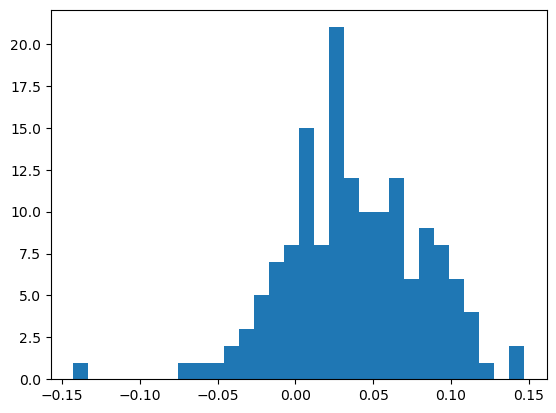

In [250]:
plt.hist(price_amen_corr[price_amen_corr != 1], bins = 30);

In [251]:
# Using regex as before, find the number of amenities for every listing and store to a new column
lstn['amen_cnt'] = lstn.amenities.apply(lambda x: len(re.findall(regex_string, x)))
lstn.amen_cnt

0       20
1       10
2       18
3       29
4       46
        ..
3472    24
3473    29
3474    27
3475     3
3476    53
Name: amen_cnt, Length: 3477, dtype: int64

In [254]:
# Find the correlation coefficient between the number of amenities listed and the price
np.corrcoef(lstn.amen_cnt, lstn.price)[0][1]

0.13731144502525244

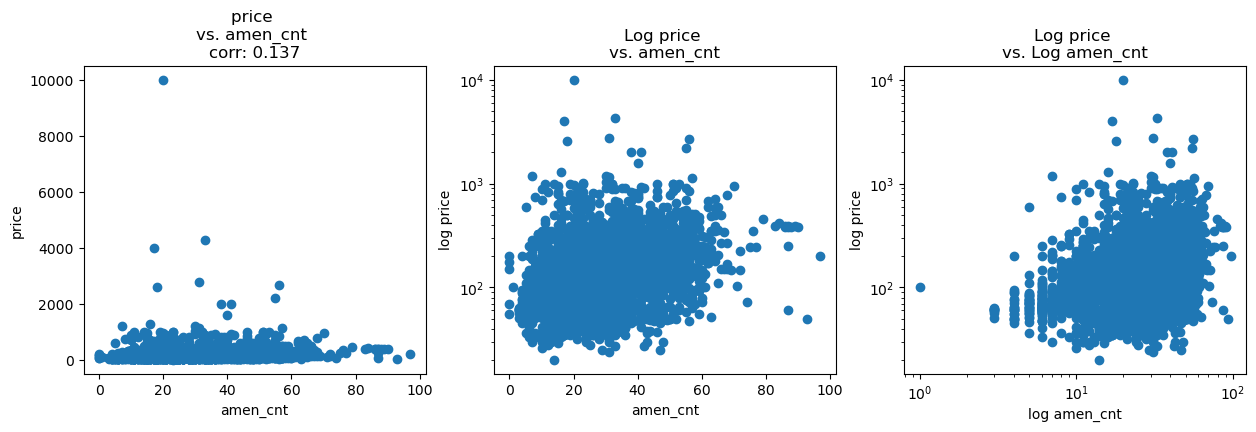

In [256]:
plot_vs_log(lstn.amen_cnt, lstn.price)

In [267]:
# Test to see if there is a stronger correlation with the log of the price
#  A lambda funciton is used to hand the 0 values (which cannot be log transformed)
np.corrcoef(lstn.amen_cnt, lstn.price.apply(lambda x: np.log(1) if x==0 else np.log(x)))[0][1]

0.3156277419865199

# APPENDIX OR JUNK

In [117]:
'Pack \\u2019n p'

'Pack \\u2019n p'

In [120]:
amn_counts[amn_counts >= 100].index[-1]

'Pack \\u2019n play/Travel crib - available upon request'

In [127]:
len([i for i in lstn.amenities if '\\u2019n' in i])

382

In [140]:
df = lstn['amenities']

In [141]:
df

0       ["Shampoo", "Carbon monoxide alarm", "Wifi", "...
1       ["Wifi", "Carbon monoxide alarm", "Hot water",...
2       ["Shampoo", "Carbon monoxide alarm", "Wifi", "...
3       ["Wifi", "Kitchen", "First aid kit", "Refriger...
4       ["Wifi", "Window guards", "Kitchen", "Long ter...
                              ...                        
3472    ["Wifi", "Stove", "Kitchen", "Dishwasher", "Re...
3473    ["Wifi", "Stove", "Keypad", "Kitchen", "Dishwa...
3474    ["Wifi", "Stove", "Keypad", "Kitchen", "Dishwa...
3475                        ["Wifi", "Microwave", "Oven"]
3476    ["Clothing storage: wardrobe and closet", "Cit...
Name: amenities, Length: 3477, dtype: object

In [ ]:
#regex_string = '(?<=")[^"]+(?=",)'
regex_string_new = '(?<=")[^"]+(?="[,\]])'